In [1]:
# Definition der benötigten Funktionspakete

import numpy as np
#import sdeint
import matplotlib.pyplot as plt
from scipy import signal
#import os
import math

## Teil 1 - Rauschen und das Parseval-Theorem

In [2]:
# importiere Daten und teile in Vektoren auf

#data = np.loadtxt("signal and noise example.txt")
data = np.loadtxt("harmOsc.txt")
t = data[:,0]
x = data[:,1]

In [3]:
# extrahiere nützliche Parameter

sampling_time = t[1]-t[0]
total_time = t[-1]
N = len(x)
n_vector = np.linspace(1,N,N)
print(sampling_time)
print(total_time)
print(N)

0.001
100.0
100001


## Wir "messen" unser Signal mit einem simulierten Analog-Digital-Konverter (ADC)

In [4]:
# simulierter ADC

Delta_t = 1 # zeitl. Abstand der Messpunkte in den gewählten Einheiten: für einen Zeitvektor t mit Abständen von je 1 Nanosekunde misst unser ADC einen Datenpunkt alle Delta_t Nanosekunden
U_max = 10.0 # maximal messbarer Wert: alle grösseren Werte werden als U_max angezeigt ("clipping")
U_min = 0.00001 # minimaler messbarer Spannungsunterschied der Signalwerte: Spannungsauflösung des ADC
U_noise = 0.005 # Standardabweichung des Spannungsrauschens, das dem Signal durch den Messprozess hinzigefügt wird

# Initialisierung der Messvektoren
n_mess = math.floor(N/Delta_t)-1 # Anzahl gemesener Punkte. "floor" rundet ab
n = range(n_mess) # wird für for loop benötigt, enthält 0 und n_mess als untere und obere Grenze von n
#print(n_mess)
t_mess = np.zeros(n_mess) # leerer Vektor, um die Zeitwerte zu erfassen
U_mess = np.zeros(n_mess) # leerer Vektor, um die Spannungswerte zu erfassen
noise_mess = np.zeros(n_mess) # leerer Vektor, um eine Messung ohne Signal zu erfassen -  eine Kalibrationsmessung

for i in n:
    t_mess[i] = t[(i+1)*Delta_t] # jeder (i+1)*Delta_t-te Punkt wird gemessen
    U_mess[i] = np.clip(U_min*round((x[(i+1)*Delta_t]+np.random.normal(0,U_noise))/U_min,0),-U_max,U_max) # numpy.clip limitiert die maximalen Werte auf [-U_max,U_max]
    noise_mess[i] = np.clip(U_min*round(np.random.normal(0,U_noise)/U_min,0),-U_max,U_max) # nur Rauschen ohne x, separater Datensatz

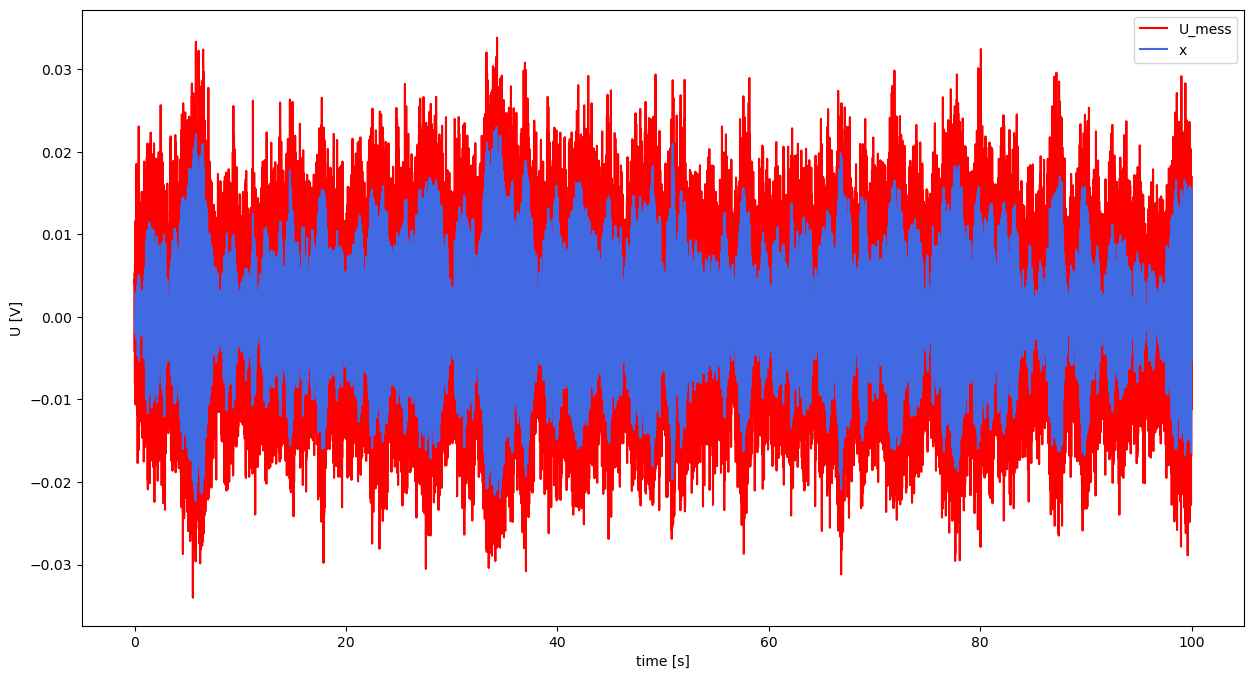

In [12]:
_, ax = plt.subplots(figsize=(15, 8))
ax.plot(t_mess, U_mess, color='red', label="U_mess")
ax.plot(t, x, color='royalblue', label="x")
#ax.plot(t_mess, noise_mess, color='purple', label="noise_mess")
ax.set_aspect('auto', 'datalim')
#ax.set_xlim([20, 21])
#ax.set_ylim([1e-12, 1e-3])
ax.set_xlabel('time [s]')
ax.set_ylabel('U [V]')
ax.legend()

#save figure
#plt.savefig('exercise1.png', dpi=setdpi)
#rc("pdf", fonttype=42)
#plt.savefig("exercise1.pdf", dpi=setdpi)

In [10]:
# berechne PSD von x
fx,PSDx = signal.periodogram(x,1/sampling_time,return_onesided=True,scaling='density')
Lx = len(fx)
#print(Lx)

# berechne PSD von U_mess
fu,PSDu = signal.periodogram(U_mess,1/(Delta_t*sampling_time),return_onesided=True,scaling='density')
Lu = len(fu)
#print(Lu)

# berechne PSD von noise_mess
fn,PSDn = signal.periodogram(noise_mess,1/(Delta_t*sampling_time),return_onesided=True,scaling='density')
Ln = len(fn)
#print(Ln)

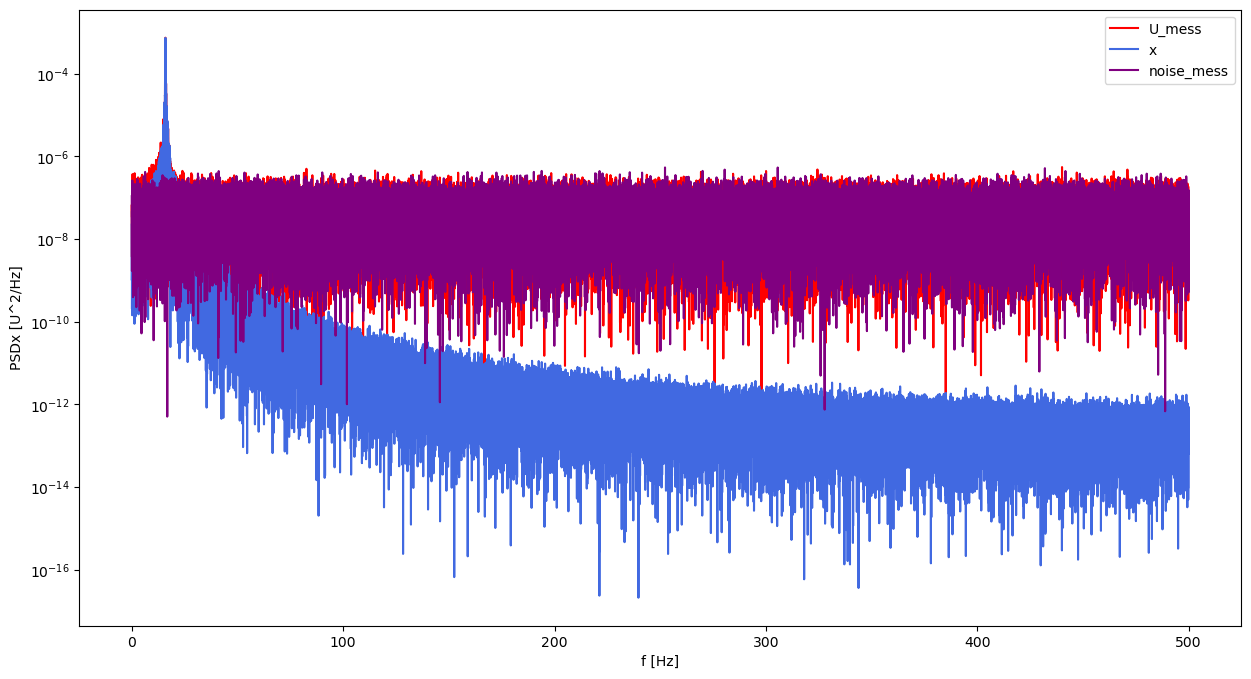

In [13]:
_, ax = plt.subplots(figsize=(15, 8))
ax.plot(fu[1:-1], PSDu[1:-1], color='red', label="U_mess")
ax.plot(fx[1:-1], PSDx[1:-1], color='royalblue', label="x")
ax.plot(fn[1:-1], PSDn[1:-1], color='purple', label="noise_mess")
#ax.plot(fn[1:-1], PSDn[1:-1]+PSDx[1:-1], color='purple', label="combined PSD")
ax.set_aspect('auto', 'datalim')
ax.set_xlabel('f [Hz]')
ax.set_ylabel('PSDx [U^2/Hz]')
ax.legend()
ax.set_yscale("log")
#plt.xlim([15, 17])
#plt.ylim([1e-12, 1e-3])

In [14]:
# verwende verschiedene Methoden, um die Varianz zu berechnen (check Parseval-Theorem)

variance1 = np.var(U_mess)
variance2 = sum(PSDu)*(fu[2]-fu[1])
variance3 = sum(PSDx)*(fx[2]-fx[1])
variance4 = sum(PSDn)*(fn[2]-fn[1]) + sum(PSDx)*(fx[2]-fx[1])

print(variance1)
print(variance2)
print(variance3)
print(variance4)

7.680983187149376e-05
7.680983187149396e-05
5.1956689839502465e-05
7.691083609414133e-05


## Teil 2.1 - Filtern von weissem Rauschen

In [15]:
L2 = 10001 # Länge des Datenvektors
t2 = np.linspace(0, L2-1, L2) # Zeitvektor von Punkten mit Abstand 1 in Einheit von Nanosekunden (als konkretes Beispiel)
x2 = np.random.normal(0,1,L2)

In [16]:
# implementiere einen einfachen Tiefpassfilter durch mitteln

def LP_filter(x_sample, N_num):
    # N_num ist die Anzahl Werte vor und nach jedem originalen Wert, die gemittelt werden
    N_av = 2*N_num+1 # Filterlänge
    n_x = len(x_sample) # Anzahl des Messwerte in x
    x_filtered = x_sample.copy() # wir erstellen eine Kopie von x, um die neuen Werte hineinzuschreiben
    for n in range(N_num,n_x-N_num): # wir ignoriernen wir N_num ersten und letzte Werte
        x_filtered[n] = sum(x_sample[n-N_num:n+N_num+1])/N_av # Mittelwert
    return x_filtered

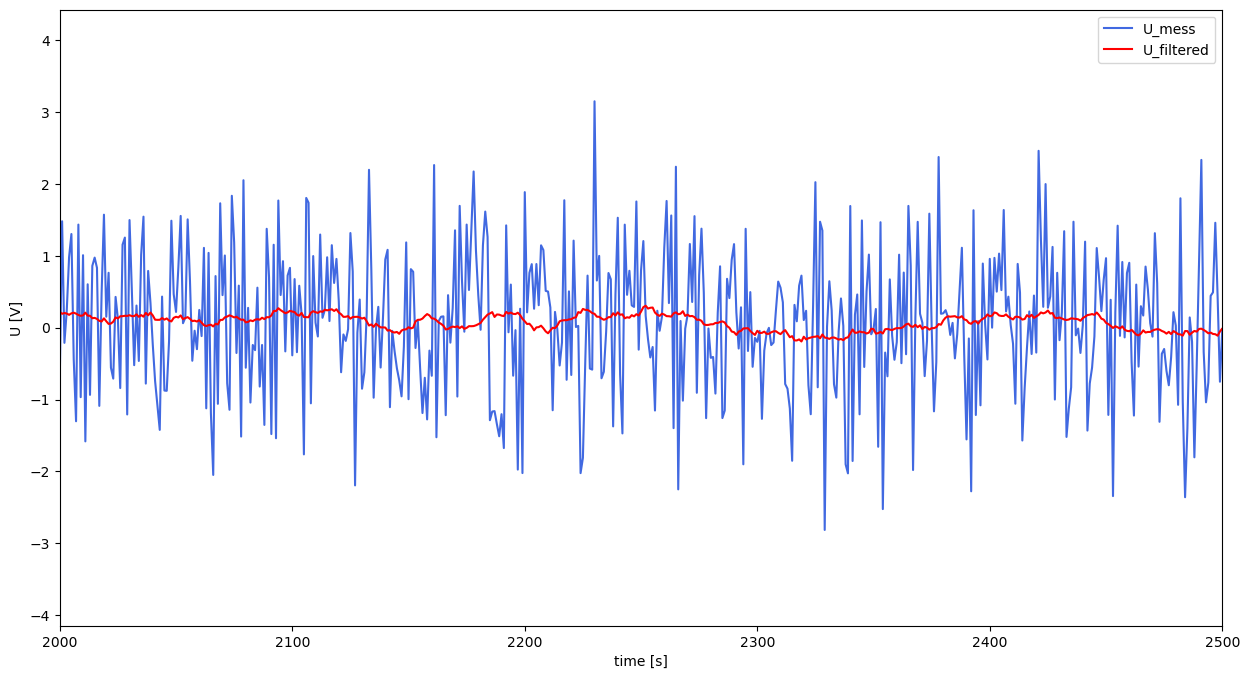

In [33]:
# filtere x2
x2_filtered = LP_filter(x2, 25)

_, ax = plt.subplots(figsize=(15, 8))
ax.plot(t2, x2, color='royalblue', label="U_mess")
ax.plot(t2, x2_filtered, color='red', label="U_filtered")
#ax.plot(t, x, color='orange', label="U_filtered")
ax.set_aspect('auto', 'datalim')
ax.set_xlim([2000,2500])
ax.set_xlabel('time [s]')
ax.set_ylabel('U [V]')
ax.legend()

In [22]:
# definiere Auto-Kovarianzfunktion (aus Übungslösung kopiert)

def auto_covariance_fast(x_sample, delta):
    # Den Fall delta = 0 müssen wir separat behandeln, weil x[:-0] ein leeres Array gibt.
    if delta == 0:
        autocov = np.var(x_sample)
    else:
        # Wir subtrahieren erst den Mittelwert vom ganzen Array
        x_mean = np.mean(x_sample)
        x_residue = x_sample - x_mean
        
        # Durch Array-Slicing erhalten wir die relevanten überlappenden Teilarrays, von denen wir
        # den Mittelwert subtrahieren. Da wir mit Numpy-Arrays arbeiten, wird die anschliessende
        # Multiplikation elementweise durchgeführt. Die Elemente des resultierenden Arrays werden
        # mit np.sum effizient aufsummiert.
        autocov = np.sum(x_residue[:-delta] * x_residue[delta:]) / (N - delta)
        
    return autocov

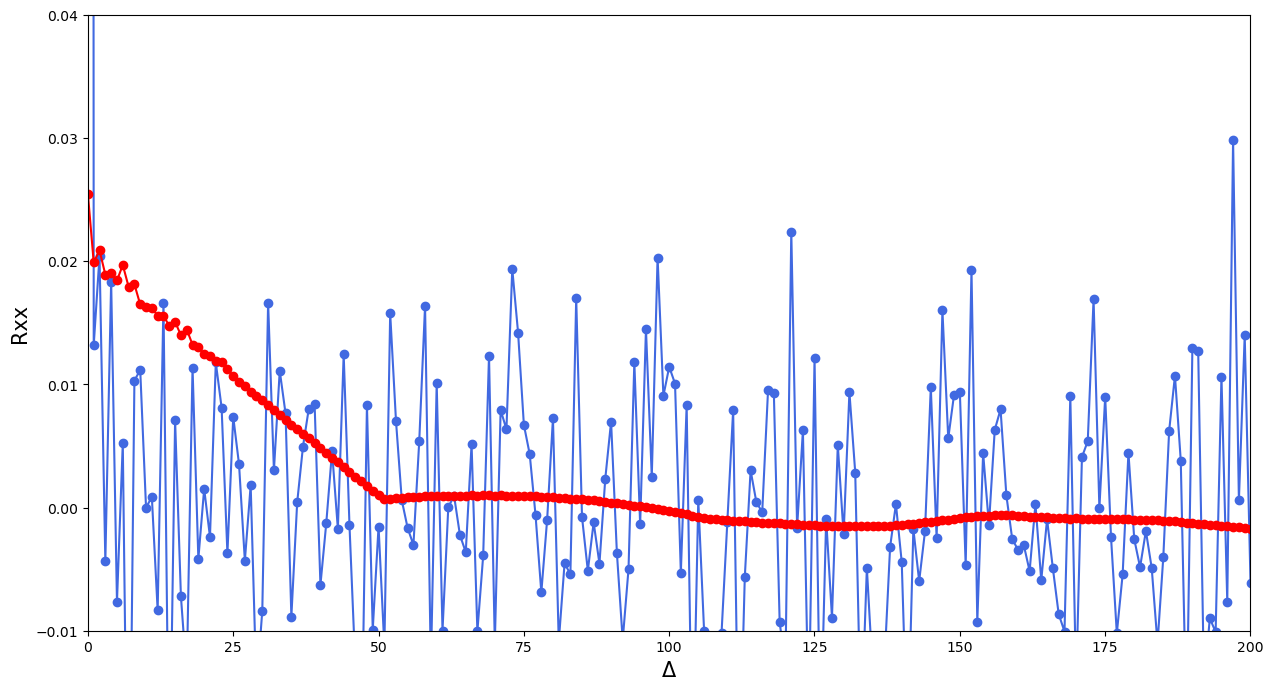

In [34]:
# wende Funktion auf Beispiele an
N = len(x2)  # Anzahl Datenpunkte
dt = t2[1] - t2[0]  # Zeitdifferenz zwischen zwei Datenpunkten.
tau = np.arange(N-1) * dt  # Tau-Achse für die Autokovarianz

# Initialisiere ein leeres Array mit der richtigen Länge für die Autokovarianz als Funktion von tau oder delta
r_xx2 = np.zeros(N)
r_xx2_filtered = np.zeros(N)

# Berechne die Autokovarianz für jedes delta.
for delta in range(N-1):
    r_xx2[delta] = auto_covariance_fast(x2, delta)

for delta in range(N-1):
    r_xx2_filtered[delta] = auto_covariance_fast(x2_filtered, delta)    
    
lags = np.linspace(0, N, N)

fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(lags, r_xx2, linestyle='-', color='royalblue', marker='o', markerfacecolor='royalblue')
ax.plot(lags, r_xx2_filtered, linestyle='-', color='red', marker='o', markerfacecolor='red')
ax.set_xlabel('$\Delta$', fontsize = 15)
ax.set_ylabel('Rxx', fontsize = 15)
plt.xlim([0, 200])
plt.ylim([-0.01, 0.04])
plt.show()

## Teil 2.2 - Filtern von Sinussignal mit weissem Rauschen

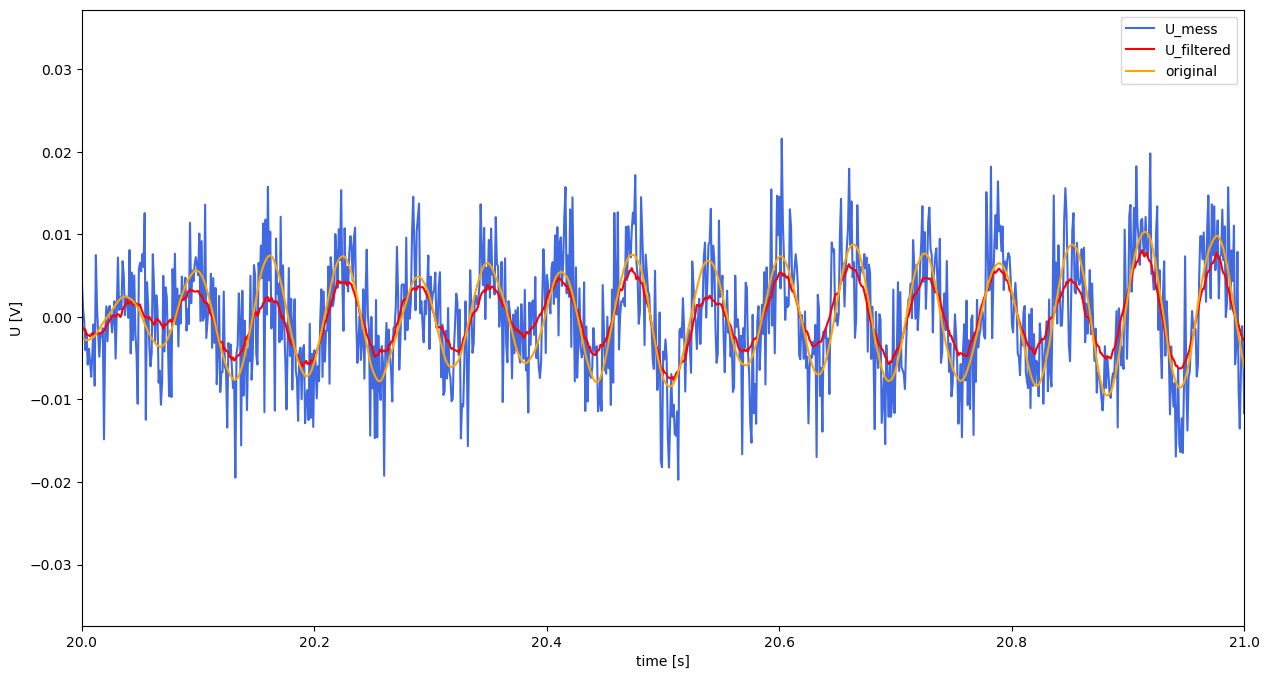

In [49]:
# filtere U_mess
U_filtered = LP_filter(U_mess, 15)

_, ax = plt.subplots(figsize=(15, 8))
ax.plot(t_mess, U_mess, color='royalblue', label="U_mess")
ax.plot(t_mess, U_filtered, color='red', label="U_filtered")
ax.plot(t, x, color='orange', label="original")
ax.set_aspect('auto', 'datalim')
#ax.ylim([-0.02, 0.02])
ax.set_xlim([20, 21])
ax.set_xlabel('time [s]')
ax.set_ylabel('U [V]')
ax.legend()

plt.show()

In [50]:
# berechne gefilterte PSD

fu,PSDu_filtered = signal.periodogram(U_filtered,1/sampling_time,return_onesided=True)

(1e-12, 0.001)

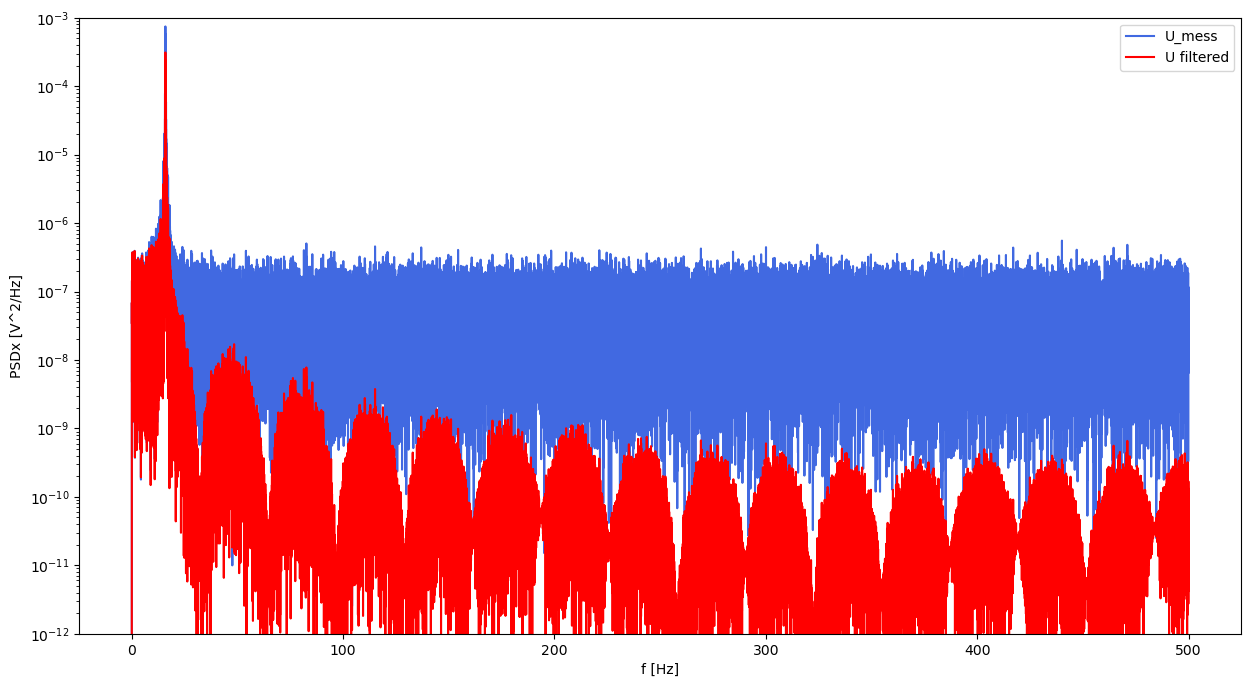

In [51]:
_, ax = plt.subplots(figsize=(15, 8))
ax.plot(fu, PSDu, color='royalblue', label="U_mess")
ax.plot(fu, PSDu_filtered, color='red', label="U filtered")
ax.set_aspect('auto', 'datalim')
ax.set_xlabel('f [Hz]')
ax.set_ylabel('PSDx [V^2/Hz]')
ax.legend()
ax.set_yscale("log")
ax.set_ylim([1e-12, 1e-3])

## Teil 3 - WAV File (NOT USED)

In [40]:
N_sound = 200001 # Länge des Datenvektors
t_sound = np.linspace(0, 10, N_sound) # Zeitvektor von Punkten mit Abstand 1 in Einheit von Nanosekunden (als konkretes Beispiel)
# t_tot = N ns für unser Beispiel

f_sig1 = 600.0
Amp1 = 1.0 
sig1 = Amp1*np.cos(2*np.pi*f_sig1*t_sound) # Sinuswelle
noise_amp = 0.2
noise1 = np.random.normal(0,noise_amp,N_sound) # normalverteiltes Rauschen mit Standardabweichung noise_amp
sound1 = sig1 + noise1 # das zu beobachtendes Spannungssignal mit Frequenz f_sig in Einheiten von Volt V

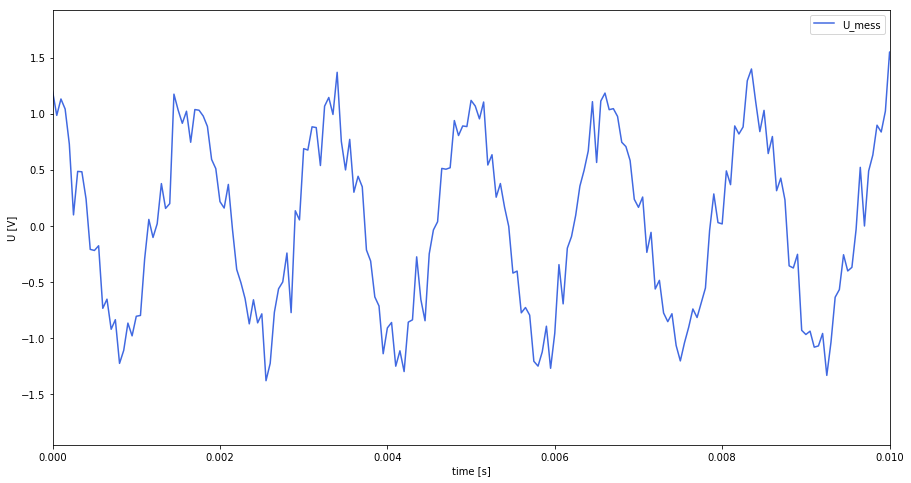

In [42]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(t_sound, sound1, color='royalblue', label="U_mess")
ax.set_aspect('auto', 'datalim')
#ax.set_ylim([-0.02, 0.02])
ax.set_xlim([0, 0.01])
ax.set_xlabel('time [s]')
ax.set_ylabel('U [V]')
ax.legend()

plt.show()

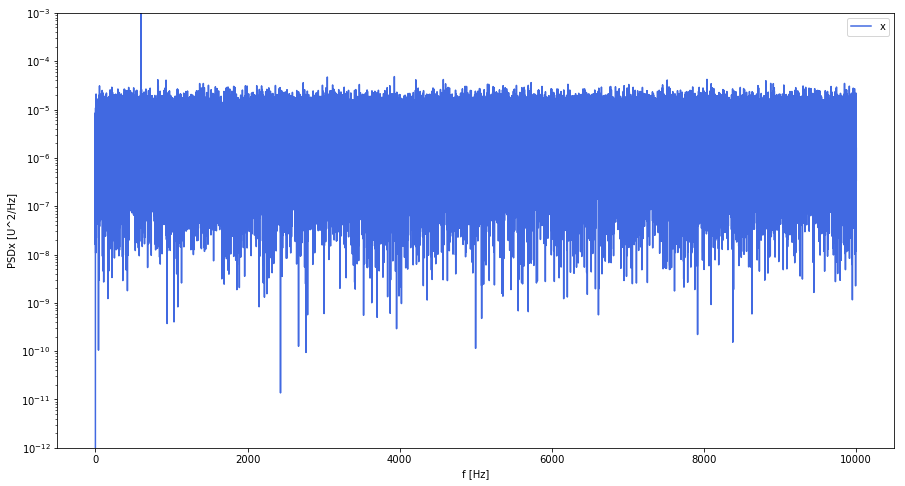

In [44]:
# berechne gefilterte PSD

f_sound,PSD_sound = signal.periodogram(sound1,20000,return_onesided=True)

fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(f_sound, PSD_sound, color='royalblue', label="x")
ax.set_aspect('auto', 'datalim')
ax.set_xlabel('f [Hz]')
ax.set_ylabel('PSDx [U^2/Hz]')
ax.legend()
ax.set_yscale("log")
ax.set_ylim([1e-12, 1e-3])

plt.show()

In [45]:
import scipy
from scipy.io.wavfile import write
scipy.io.wavfile.write("Sound1.wav", 20000, sound1)

## Teil 4.1 - Mitteln im Frequenzraum

In [56]:
# filtere U_mess
PSD_filtered = LP_filter(PSDu, 20) # wir verwenden dieselbe Funktion wie für zeitliches Mitteln, aber hier verwenden wir Datenpunkte der PSD an aufeinanderfolgenden Frequenzen

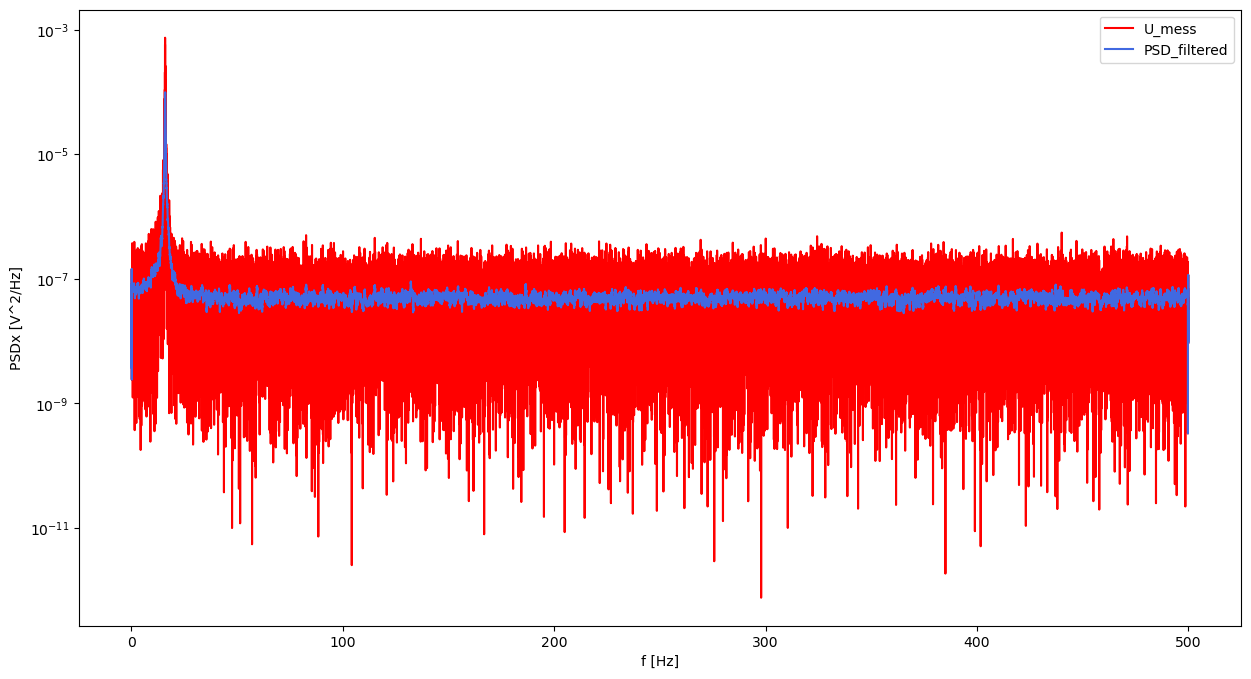

In [57]:
_, ax = plt.subplots(figsize=(15, 8))
ax.plot(fu[1:-1], PSDu[1:-1], color='red', label="U_mess")
ax.plot(fu[1:-1], PSD_filtered[1:-1], color='royalblue', label="PSD_filtered")
#ax.plot(fn[1:-1], PSDn[1:-1], color='purple', label="noise_mess")
#ax.plot(fn[1:-1], PSDn[1:-1]+PSDx[1:-1], color='purple', label="combined PSD")
ax.set_aspect('auto', 'datalim')
ax.set_xlabel('f [Hz]')
ax.set_ylabel('PSDx [V^2/Hz]')
ax.legend()
ax.set_yscale("log")
#ax.set_xlim([15, 17])
#ax.set_ylim([1e-12, 1e-3])

## Teil 4.2 - Mitteln von Spektren

In [62]:
N_PSD = 100 # Anzahl Repetitionen der PSD
L_vec = 1000 # Länge des Frequenzvektors

f_PSD = np.linspace(0,L_vec,L_vec+1) # generiere Frequenzen
x_PSD = np.zeros((L_vec+1,N_PSD))

for n1 in range(N_PSD):
    for n2 in range(L_vec+1):
        x_PSD[n2,n1] = (np.random.normal(0, 1))**2 # generiere PSD Werte für N_PSD wiederholte "Messungen"
        
x_PSD_av = np.mean(x_PSD, axis=1) # mittle PSD Werte bei jeder Frequenz einzeln       

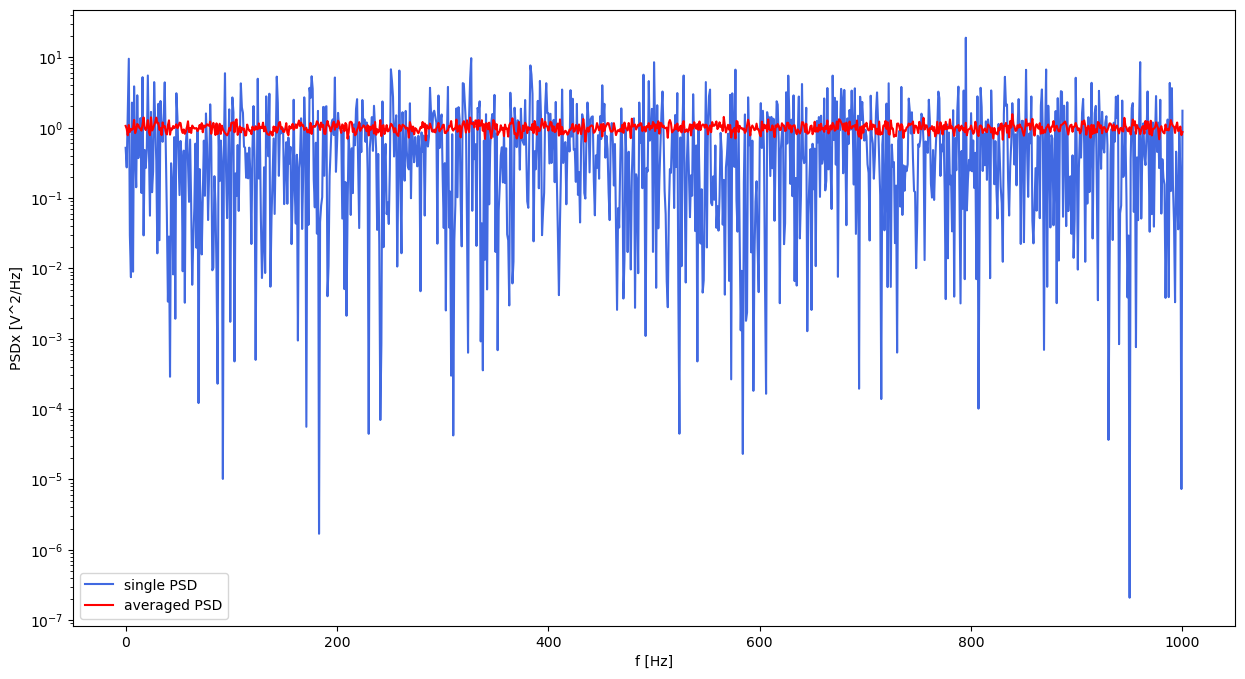

In [64]:
_, ax = plt.subplots(figsize=(15, 8))
ax.plot(f_PSD, x_PSD[:,1], color='royalblue', label="single PSD")
ax.plot(f_PSD, x_PSD_av, color='red', label="averaged PSD")
ax.set_aspect('auto', 'datalim')
ax.set_xlabel('f [Hz]')
ax.set_ylabel('PSDx [V^2/Hz]')
ax.legend()
ax.set_yscale("log")
#ax.set_ylim([1e-12, 1e-3])